In [1]:
%load_ext autoreload
%autoreload 
import sys
from pathlib import Path
ProjectRoot = Path().cwd().parent.parent
sys.path.append(str(ProjectRoot))

In [2]:
from src.data.modelData import ObjectDetection

In [3]:
data_handler = ObjectDetection(class_names=['SH35_PF08460', 'Lysozyme_PF16754', 'Lysozyme_PF18013', 'Lysozyme_PF01374', 'Lysozyme_PF13702', 'Lysozyme_PF11860', 'Lysozyme_PF03245'], img_dim=224)
#data_handler.create_coco_data(augment_data=False, num_augs=1000, img_h=224, img_w=1000)

In [4]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


mkdir: cannot create directory ‘/home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset’: File exists
trash-put: cannot trash non existent '/home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/images_224'


100%|██████████| 23/23 [00:16<00:00,  1.39it/s]

WARNING [11/22 16:06:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 16:06:13 d2.data.datasets.coco]: Loaded 2047 images in COCO format from /home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/train.json
{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/img_Q2A095_9CAUD_PF03245_Lysozyme.png', 'height': 224, 'width': 1000, 'image_id': 3054, 'annotations': [{'iscrowd': 0, 'bbox': [23, 0, 125, 224], 'category_id': 6, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


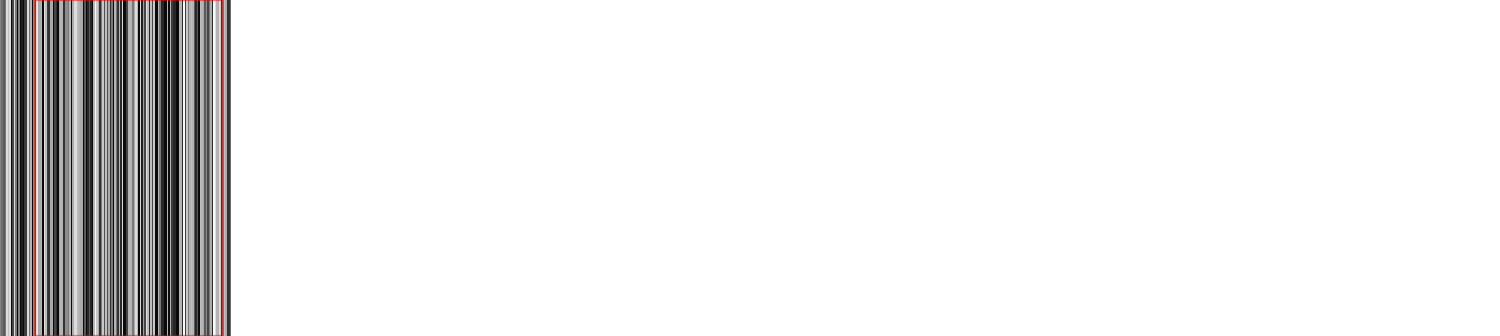

{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/img_A0A0F4QT46_9GAMM_PF16754_Lysozyme.png', 'height': 224, 'width': 1000, 'image_id': 490, 'annotations': [{'iscrowd': 0, 'bbox': [9, 0, 149, 224], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


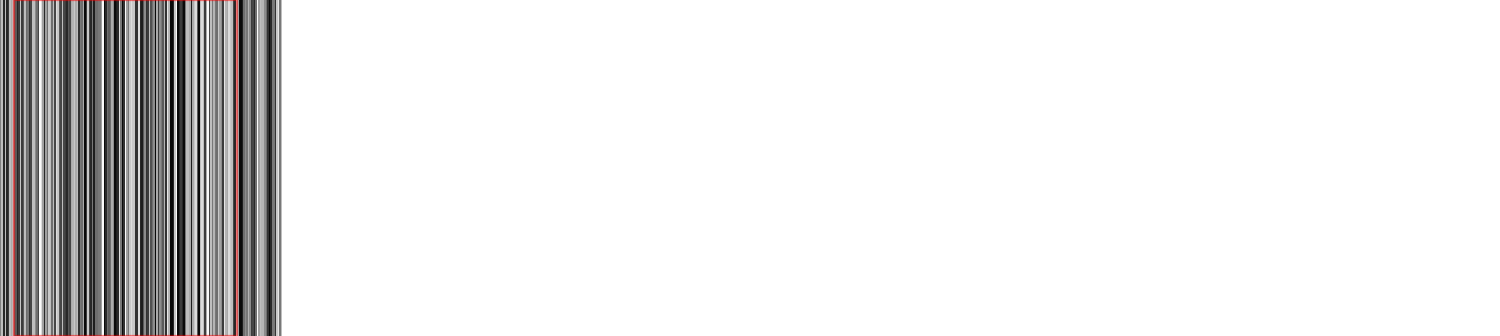

{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/img_H0DEX0_9STAP_PF08460_SH3_5.png', 'height': 224, 'width': 1000, 'image_id': 315, 'annotations': [{'iscrowd': 0, 'bbox': [43, 0, 64, 224], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


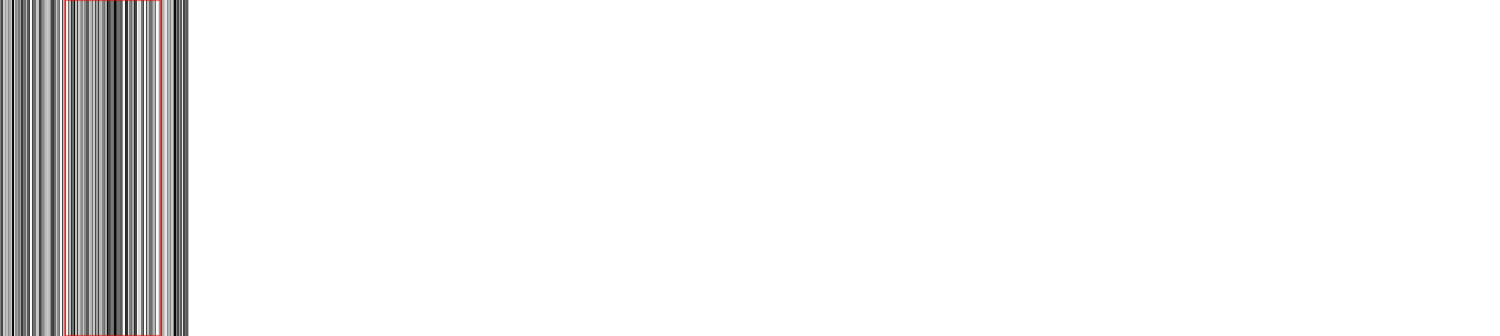

In [5]:
from detectron2.data.datasets import register_coco_instances
# images used should be at 224x1000 dim
register_coco_instances("ballon_train", {}, "/home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/train.json", "/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/")
register_coco_instances("ballon_val", {}, "/home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/val.json", "/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/")
register_coco_instances("ballon_test", {}, "/home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224//test.json", "/home/satish27may/ProteinDomainDetection/data/PfamData/images_224/")
balloon_metadata = MetadataCatalog.get("balloon_train")

! mkdir /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset
! trash-put /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/class1
! trash-put /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/images_224
! mkdir /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/class1
! cp   /home/satish27may/ProteinDomainDetection/data/PfamData/images_224/*  /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/class1/
#! mv /home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset/images_224 /home/satish27may/DetectoRS_mmdetect/mmdetection/data/torch_dataset/class1
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


custom_dataset = datasets.ImageFolder('/home/satish27may/ProteinDomainDetection/data/PfamData/torch_dataset', transform=transforms.ToTensor())
custom_data_loader = DataLoader(dataset=custom_dataset,batch_size=128)
data_mean, data_std = get_mean_std(custom_data_loader)

data_mean = data_mean.numpy().tolist()
data_std = data_std.numpy().tolist()

dataset_dicts = DatasetCatalog.get("ballon_train")
for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=1.5)
    bbox = d['annotations'][0]['bbox']
    out = visualizer.draw_box((bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]), edge_color='red', line_style='-')
    cv2_imshow(out.get_image()[:, :, ::-1])

In [6]:
! trash-put /home/satish27may/ProteinDomainDetection/models/*

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
img_h, img_w = 224, 1000
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ballon_train",)
cfg.DATASETS.TEST = ("ballon_val",)
cfg.MODEL.PIXEL_MEAN = data_mean
cfg.MODEL.PIXEL_STD = data_std
cfg.INPUT.RANDOM_FLIP = "none"
cfg.TEST.DETECTIONS_PER_IMAGE = 100


cfg.TEST.AUG.FLIP = True
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 9e-4  # pick a good LR
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.MODEL.RETINANET.IOU_THRESHOLDS = [0.4, 0.8]
cfg.SOLVER.MAX_ITER = 3000  
cfg.MODEL.RETINANET.NUM_CLASSES = len(data_handler.class_names)


cfg.OUTPUT_DIR = '/home/satish27may/ProteinDomainDetection/models'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

Loading config /home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[11/22 16:06:19 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (63, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (63,) in the model! You might want to double check if this is expected.


[11/22 16:06:20 d2.engine.train_loop]: Starting training from iteration 0
[11/22 16:06:34 d2.utils.events]:  eta: 0:32:19  iter: 19  total_loss: 0.1488  loss_cls: 0.1294  loss_box_reg: 0.02071  time: 0.6786  data_time: 0.0174  lr: 1.7981e-05  max_mem: 1202M
[11/22 16:06:47 d2.utils.events]:  eta: 0:32:19  iter: 39  total_loss: 0.6125  loss_cls: 0.539  loss_box_reg: 0.08645  time: 0.6670  data_time: 0.0048  lr: 3.595e-05  max_mem: 1202M
[11/22 16:07:00 d2.utils.events]:  eta: 0:32:10  iter: 59  total_loss: 1.176  loss_cls: 1.005  loss_box_reg: 0.1611  time: 0.6644  data_time: 0.0048  lr: 5.3895e-05  max_mem: 1202M
[11/22 16:07:14 d2.utils.events]:  eta: 0:32:00  iter: 79  total_loss: 1.36  loss_cls: 1.175  loss_box_reg: 0.1796  time: 0.6642  data_time: 0.0046  lr: 7.1806e-05  max_mem: 1202M
[11/22 16:07:27 d2.utils.events]:  eta: 0:31:50  iter: 99  total_loss: 1.056  loss_cls: 0.8587  loss_box_reg: 0.1561  time: 0.6638  data_time: 0.0048  lr: 8.967e-05  max_mem: 1202M
[11/22 16:07:40 d2

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("ballon_val", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ballon_val")
print(trainer.test(cfg, trainer.model, evaluator))

WARNING [11/22 16:39:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 16:39:28 d2.data.datasets.coco]: Loaded 878 images in COCO format from /home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/val.json
[11/22 16:39:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/22 16:39:28 d2.data.common]: Serializing 878 elements to byte tensors and concatenating them all ...
[11/22 16:39:28 d2.data.common]: Serialized dataset takes 0.25 MiB
WARNING [11/22 16:39:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 16:39:28 d2.data.datasets.coco]: Loaded 878 images in COCO format from /home/satish27may/ProteinDomainDetection/data/PfamData/annotations_224/val.json
[11/22 16:39:28 d2.data.dataset_mapper]: [DatasetMapper] 

Without augmentations
=====================
COCOeval_opt.accumulate() finished in 0.07 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.768
[11/22 16:42:00 d2.evaluation.coco_evaluation]: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm   |  APl   |
|:------:|:------:|:------:|:-----:|:------:|:------:|
| 35.656 | 41.698 | 38.199 |  nan  | 20.000 | 35.695 |
[11/22 16:42:00 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/22 16:42:00 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| PF08460    | 32.024 | PF18013    | 5.919  | PF16754    | 2.831  |
| PF01374    | 55.469 | PF13702    | 50.893 | PF11860    | 20.077 |
| PF03245    | 82.380 |            |        |            |        |
[11/22 16:42:00 d2.engine.defaults]: Evaluation results for ballon_val in csv format:
[11/22 16:42:00 d2.evaluation.testing]: copypaste: Task: bbox
[11/22 16:42:00 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/22 16:42:00 d2.evaluation.testing]: copypaste: 35.6562,41.6979,38.1985,nan,20.0000,35.6953
OrderedDict([('bbox', {'AP': 35.65619871070893, 'AP50': 41.69789942418811, 'AP75': 38.198502555791144, 'APs': nan, 'APm': 20.0, 'APl': 35.695309868261866, 'AP-PF08460': 32.02401326523716, 'AP-PF18013': 5.919246166985234, 'AP-PF16754': 2.8313595282706716, 'AP-PF01374': 55.46874988541875, 'AP-PF13702': 50.89294522046027, 'AP-PF11860': 20.076870759218448, 'AP-PF03245': 82.38020614937199})])




With augmentations
====================
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.436
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.413
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.377
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.682
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
[11/22 13:58:05 d2.evaluation.coco_evaluation]: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm   |  APl   |
|:------:|:------:|:------:|:-----:|:------:|:------:|
| 37.544 | 43.586 | 41.294 |  nan  | 10.000 | 37.655 |
[11/22 13:58:05 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/22 13:58:05 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| PF08460    | 48.560 | PF18013    | 3.927  | PF16754    | 6.735  |
| PF01374    | 54.044 | PF13702    | 48.528 | PF11860    | 21.452 |
| PF03245    | 79.560 |            |        |            |        |
[11/22 13:58:05 d2.engine.defaults]: Evaluation results for ballon_val in csv format:
[11/22 13:58:05 d2.evaluation.testing]: copypaste: Task: bbox
[11/22 13:58:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/22 13:58:05 d2.evaluation.testing]: copypaste: 37.5439,43.5857,41.2941,nan,10.0000,37.6547
OrderedDict([('bbox', {'AP': 37.54385054910935, 'AP50': 43.58565184973131, 'AP75': 41.294074336198285, 'APs': nan, 'APm': 10.0, 'APl': 37.65466371354227, 'AP-PF08460': 48.56045121798618, 'AP-PF18013': 3.9267674053574044, 'AP-PF16754': 6.7352599447230705, 'AP-PF01374': 54.04437750886011, 'AP-PF13702': 48.52783692621661, 'AP-PF11860': 21.452057325764077, 'AP-PF03245': 79.560203514858})])